# Neural Networks Basics

## Импорты

In [1]:
from math import ceil
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
RANDOM_STATE = 32

## Загрузка и подготовка данных

In [3]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
85,6.0,3.4,4.5,1.6,1.0
95,5.7,3.0,4.2,1.2,1.0
69,5.6,2.5,3.9,1.1,1.0
14,5.8,4.0,1.2,0.2,0.0
101,5.8,2.7,5.1,1.9,2.0


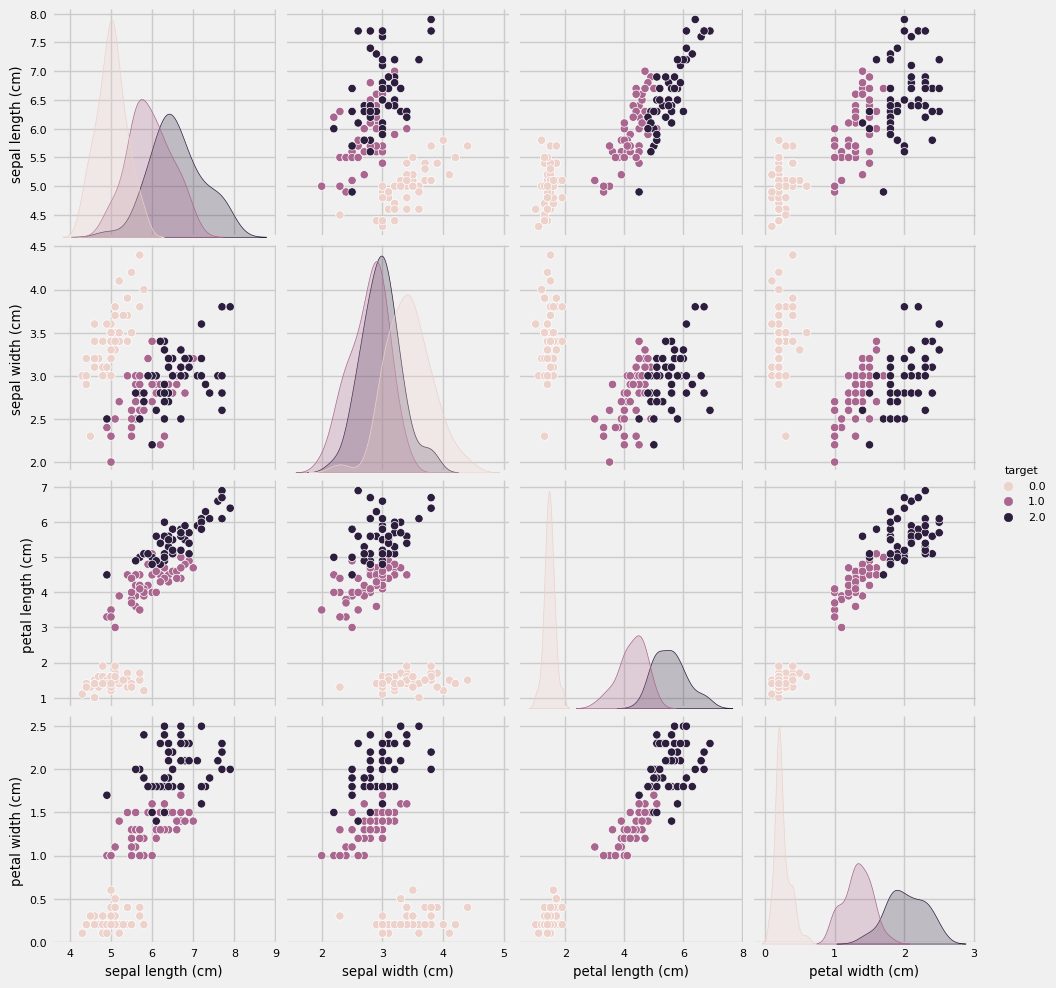

In [4]:
sns.pairplot(data, hue='target')
plt.show()

Функции для работы с данными (самописный аналог функций из sklearn https://github.com/Andrey-Patrakov/mbw)

In [5]:
def train_test_split(*arrays,
                     random_state=None,
                     train_size=None,
                     test_size=None,
                     shuffle=True):
    results = []

    if train_size is None:
        if test_size is None:
            test_size = 0.25

        train_size = 1 - test_size

    train_size = max(train_size, 0)
    train_size = min(train_size, 1)
    indexes = np.arange(len(arrays[0]))

    if random_state is not None:
        np.random.seed(int(random_state))

    if shuffle:
        np.random.shuffle(indexes)

    idx = ceil(len(indexes) * train_size)
    train_idx = indexes[:idx]
    test_idx = indexes[idx:]
    for arr in arrays:
        array = np.array(arr)
        results.append(array[train_idx, ...])
        results.append(array[test_idx, ...])

    return results

In [6]:
class Scaler(ABC):

    def __init__(self) -> None:
        pass

    @abstractmethod
    def fit(self, X, y=None):
        pass

    @abstractmethod
    def transform(self, X, y=None):
        pass

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)


class StandardScaler(Scaler):

    def __init__(self) -> None:
        self._x_mean = None
        self._x_std = None

    def fit(self, X, y=None):
        X = np.array(X)
        self._x_mean = X.mean(axis=0)
        self._x_std = X.std(axis=0)

    def transform(self, X, y=None):
        if self._x_mean is None or self._x_std is None:
            raise RuntimeError(
                "StandardScaler is not fited (fit method was never called)!"
            )

        X = np.array(X)
        return (X - self._x_mean) / self._x_std

In [7]:
X, y = data[iris['feature_names']], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

In [8]:
scaller = StandardScaler()
X_train = scaller.fit_transform(X_train)
X_test = scaller.transform(X_test)

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## Своя реализация нейронной сети

In [9]:
class Layer(ABC):

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, error, lr):
        pass

    @abstractmethod
    def init_weights(self):
        pass


class Linear(Layer):

    def __init__(self, in_features: int, out_features: int):
        self._in_features = in_features
        self._out_features = out_features
        self.init_weights()

    def init_weights(self):
        self._w = 2 * np.random.random((self._in_features,
                                        self._out_features)) - 1
        self._b = 2 * np.random.random((1, self._out_features)) - 1

    def forward(self, x):
        self._cache = x
        return x @ self._w + self._b

    def backward(self, error, lr):
        self._w += (self._cache.T @ error) * lr
        self._b += np.sum(error, axis=0, keepdims=True) * lr
        return error @ self._w.T

In [10]:
class Activation(ABC):

    def __init__(self) -> None:
        self._cache = None

    @abstractmethod
    def call(self, x):
        pass

    @abstractmethod
    def deriv(self, x):
        pass

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self._cache = self.call(x)
        return self._cache

    def backward(self, error, lr=None):
        return error * self.deriv(self._cache)


class ReLU(Activation):

    def call(self, x):
        return np.maximum(0, x)

    def deriv(self, x):
        return x > 0


class LeakyReLU(Activation):

    def __init__(self, alpha=0.03) -> None:
        super().__init__()
        self._alpha = alpha

    def call(self, x):
        return np.maximum(self._alpha * x, x)

    def deriv(self, x):
        dx = np.ones_like(x)
        dx[x < 0] = self._alpha
        return dx


class Sigmoid(Activation):

    def call(self, x):
        return 1 / (1 + np.exp(np.minimum(-x, 50.0)))

    def deriv(self, x):
        return self.call(x) * (1 - self.call(x))


class Tanh(Activation):

    def call(self, x):
        return (2 / (1 + np.exp(np.minimum(-2 * x, 50.0)))) - 1

    def deriv(self, x):
        return 1 - self.call(x)**2

In [11]:
class NeuralNetwork:
    def __init__(self,
                 learning_rate=1e-3,
                 random_seed=None,
                 verbose_callback=None) -> None:

        self._layers = []
        self._lr = learning_rate
        self._random_seed = random_seed
        self._v_callback = verbose_callback
        self._fited = False

    def add(self, layer: Layer):
        self._layers.append(layer)

    def forward(self, x):
        x = np.array(x)
        for layer in self._layers:
            x = layer.forward(x)

        return x

    def backward(self, error, lr):
        error = np.array(error)
        for layer in self._layers[::-1]:
            error = layer.backward(error, lr)

        return error

    def fit(self, x, y, epochs, learning_rate=None):
        lr = learning_rate if learning_rate else self._lr
        if self._random_seed is not None and not self._fited:
            np.random.seed(self._random_seed)
            for layer in self._layers:
                if isinstance(layer, Layer):
                    layer.init_weights()

        history = {
            'epoch': [],
            'error': [],
        }

        for epoch in range(epochs):
            y_pred = self.forward(x)
            error = y - y_pred
            self.backward(error, lr)

            history['epoch'].append(epoch + 1)
            history['error'].append(error)

            if self._v_callback is not None:
                self._v_callback(self)

        return history

    def predict(self, x):
        return self.forward(x)

### Посмотрим как гиперпараметры влияют на работу модели

In [12]:
def plot_error(history, label):
    plt.plot(history['epoch'], history['loss'], label=label)

In [13]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [14]:
def test_step(nn, epoch, history):
    pred = nn.forward(X_test)
    loss = mse(np.array(y_test), pred)
    history['loss'].append(np.mean(loss))
    history['epoch'].append(epoch)
    return history

### Скорость обучения

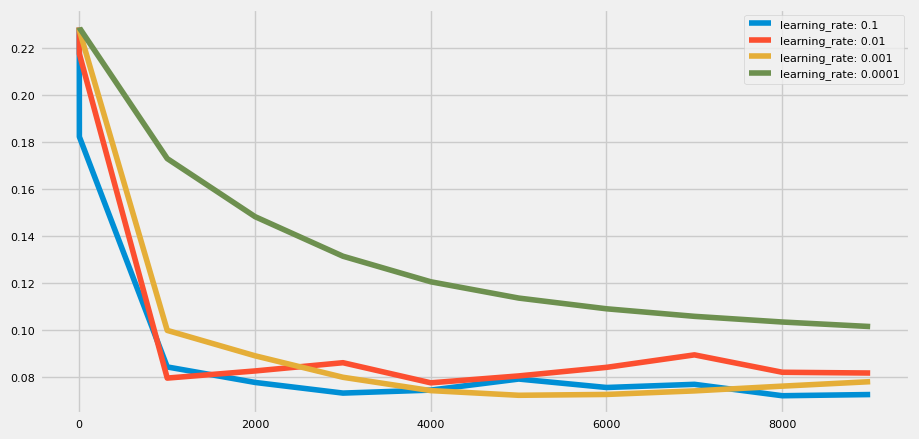

In [15]:
plt.figure(figsize=(10, 5))

random_seed = 32
learning_rate=0.001
epochs = 10_000

for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    history = {
        'loss': [],
        'epoch': []
    }

    np.random.seed(random_seed)
    nn = NeuralNetwork()
    nn.add(Linear(4, 5))
    nn.add(Sigmoid())
    nn.add(Linear(5, 3))
    nn.add(Sigmoid())

    history = test_step(nn, 0, history)
    for epoch in range(epochs):
        pred = nn.forward(np.array(X_train))
        error = y_train - pred
        nn.backward(error, learning_rate)

        if epoch % 1000 == 0:
            history = test_step(nn, epoch+1, history)

    plot_error(history, f'learning_rate: {learning_rate}')

plt.legend()
plt.show()

### Функция активации

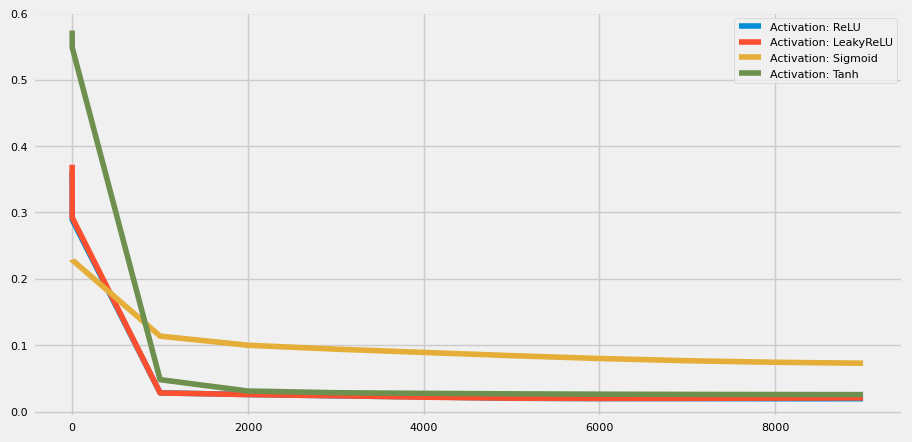

In [16]:
plt.figure(figsize=(10, 5))

random_seed = 32
learning_rate=0.0005
epochs = 10_000

for Activation in [ReLU, LeakyReLU, Sigmoid, Tanh]:
    history = {
        'loss': [],
        'epoch': []
    }

    np.random.seed(random_seed)
    nn = NeuralNetwork()
    nn.add(Linear(4, 5))
    nn.add(Activation())
    nn.add(Linear(5, 3))
    nn.add(Activation())

    history = test_step(nn, 0, history)
    for epoch in range(epochs):
        pred = nn.forward(np.array(X_train))
        error = y_train - pred
        nn.backward(error, learning_rate)

        if epoch % 1000 == 0:
            history = test_step(nn, epoch+1, history)

    plot_error(history, f'Activation: {Activation().__class__.__name__}')

plt.legend()
plt.show()

### Размер слоя

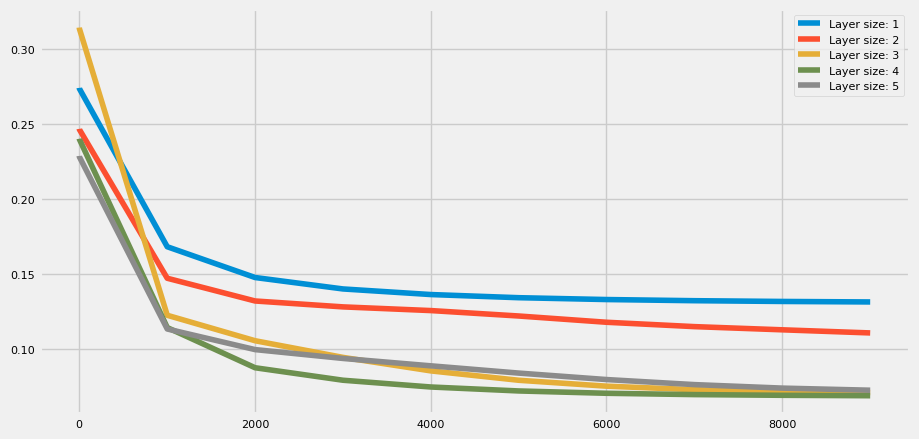

In [17]:
plt.figure(figsize=(10, 5))

random_seed = 32
learning_rate=0.0005
epochs = 10_000

for layer_size in range(1, 6):
    history = {
        'loss': [],
        'epoch': []
    }

    np.random.seed(random_seed)
    nn = NeuralNetwork()
    nn.add(Linear(4, layer_size))
    nn.add(Sigmoid())
    nn.add(Linear(layer_size, 3))
    nn.add(Sigmoid())

    history = test_step(nn, 0, history)
    for epoch in range(epochs):
        pred = nn.forward(np.array(X_train))
        error = y_train - pred
        nn.backward(error, learning_rate)

        if epoch % 1000 == 0:
            history = test_step(nn, epoch+1, history)

    plot_error(history, f'Layer size: {layer_size}')

plt.legend()
plt.show()

### Количество скрытых слоев

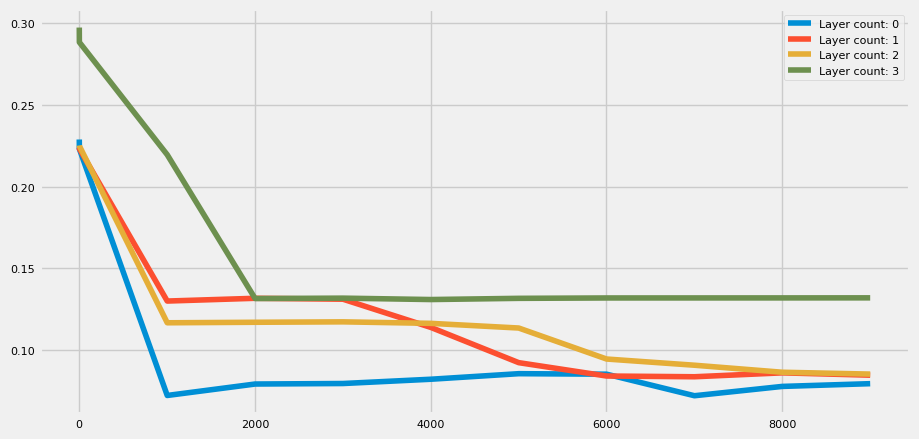

In [18]:
plt.figure(figsize=(10, 5))

random_seed = 32
learning_rate=0.005
epochs = 10_000

for layer_count in range(4):
    history = {
        'loss': [],
        'epoch': []
    }

    np.random.seed(random_seed)
    nn = NeuralNetwork()
    nn.add(Linear(4, 5))
    nn.add(Sigmoid())
        
    for _ in range(layer_count):
        nn.add(Linear(5, 5))
        nn.add(Sigmoid())
    
    nn.add(Linear(5, 3))
    nn.add(Sigmoid())

    history = test_step(nn, 0, history)
    for epoch in range(epochs):
        pred = nn.forward(np.array(X_train))
        error = y_train - pred
        nn.backward(error, learning_rate)

        if epoch % 1000 == 0:
            history = test_step(nn, epoch+1, history)

    plot_error(history, f'Layer count: {layer_count}')

plt.legend()
plt.show()

Увеличение количества эпох стабильно увеличивает точность модели, но обучение занимает больше времени. Если установить слишком малое значение, то модель недообучится. Увеличение скорости обучения ускоряет обучение модели, но слишком большое значение может иметь обратный эффект. Увеличение количества и размера слоёв улучшает качество модели, но понижает скорость обучения и повышает риск переобучения.